# 09-02 - Supervised Node Classification and Link Prediction

*June 26 2024*  

In the previous week, we introduced graph representation learning techniques that can be used to learn "feature vectors" that best represent nodes in a graph. We will now combine this with logistic regression to implement supervised node classification and supervised link prediction.

In [1]:
import pathpy as pp
import scipy as sp
from numpy import linalg as npl
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

import numpy as np
from scipy.linalg import svd

import seaborn as sns

plt.style.use('default')
sns.set_style("whitegrid")

## Supervised Node Classification

As a simple example for (binary) node classification, we use the Karate club network which contains ground truth binary class labels for nodes. We can print the network to get a description of the underlying data set.

In [2]:
n = pp.io.graphtool.read_netzschleuder_network('karate', '77')
print(n)

Uid:			0x7fee3d4b43d0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	34
Number of edges:	77

Network attributes
------------------
name:	karate (77)
description:	Network of friendships among members of a university karate club. Includes metadata for faction membership after a social partition. Note: there are two versions of this network, one with 77 edges and one with 78, due to an ambiguous typo in the original study. (The most commonly used is the one with 78 edges.)[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.
citation:	[['W. W. Zachary, "An information flow model for conflict and fission in small groups." Journal of Anthropological Research 33, 452-473 (1977).', 'https://doi.org/10.1086/jar.33.4.3629752']]
url:	https://aaronclauset.github.io/datacode.htm
tags:	['Social', 'Offline', 'Unweighted']
analyses:	{'77': {'average_degree': 4.529411764705882, 'degree_assortativity': -0.46747895436420067, 'degree_std_dev': 3.

In the description of the data, we see that there is an integer vertex property `groups` that contains the ground truth classes that we can use to train and validate our logistic regression classifier. Let's plot the network, coloring nodes according to the class labels.

In [3]:
colors = {}
colors[0] = 'orange'
colors[1] = 'CornflowerBlue'

for v in n.nodes:
    # use zero-based group indices to facilitate binary classification
    v['color'] = colors[v['groups']-1]
    v['label'] = str(v.uid)

plot_style = {}
plot_style['edge_opacity'] = 0.5
plot_style['edge_color'] = 'gray'
plot_style['node_opacity'] = 1.0
plot_style['node_size'] = 30

fr_karate = pp.layout(n, layout='FR', width=400, height=600, layout_iterations=2500, layout_force=14)

n.plot(**plot_style, layout=fr_karate)

Calculating Fruchterman-Reingold layout:  99%|█████████▉| 2486/2500 [00:00<00:00, 12693.35it/s]


We store the nodes as well as the group information in a `pandas` data frame. We can easily split this into a training and test set using the `sklearn` function `train_test_split`:

In [4]:
nodes = [(v.uid, v['groups']-1) for v in n.nodes]
data = pd.DataFrame(nodes, columns=['v', 'group'])

train, test = train_test_split(data, test_size=0.3)

In [5]:
print(train)

     v  group
19  17      0
14   2      0
12  15      1
0    0      0
6   19      0
26  29      1
30  12      0
15   1      0
27  25      1
24  22      1
5   32      1
10  10      0
25  23      1
21  30      1
20   6      0
8   33      1
7   21      0
3   28      1
32   5      0
29  26      1
17   7      0
18   3      0
9   14      1


We now need to add features to the nodes. For this, we can, for instance, use the Laplacian eigenmap approach that we introduced in Lecture 08. Let us copy the code from the previous notebooks:

In [6]:
def laplacian(network):
    A = pp.algorithms.adjacency_matrix(network, weight=False)
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    L = D - A
    return L

def normalized_laplacian(network: pp.Network):
    I = sp.sparse.identity(network.number_of_nodes())
    A = network.adjacency_matrix()
    D_inv_sqrt = sp.sparse.diags(pp.statistics.degree_sequence(network)).power(-0.5)
    L = I- D_inv_sqrt * A * D_inv_sqrt
    return L

def laplacian_embedding(network, laplacian, d=None):
    """Function that returns a vector representation of all nodes based on the entries of eigenvectors of the laplacian"""
    
    if d == None:
        d = network.number_of_nodes()-1
    
    ew, ev = sp.linalg.eig(laplacian.todense())

    # get eigenvectors and eigenvalues in ascending order, skipping the first
    index = np.argsort(ew)[1:]
    ev = ev[:,index]
    ew = ew[index]

    #ev = normalize(ev, p=2)

    vecs = {}
    for v in network.nodes.uids:
        # embedding x_ of node i in m-dimensional vector space is given by 
        # i-th component in the first m eigenvectors 
        # (ignoring the eigenvector corrresponding to zero eigenvalue)
        #embedding = ev[:,:d]
        vecs[v] = ev[network.nodes.index[v],:d].real
        for i in range(d):
            vecs[v][i] /= ew[i].real
        #vecs[v] = np.squeeze(np.asarray(ev[network.nodes.index[v],1:d+1].real))

    return vecs

The following function takes an embedding (i.e. a dictionary mapping vectors to nodes) and adds the feature dimensions to an existing `pandas` data frame. We use columns $x_0, \ldots, x_{d-1}$ to store $d$ feature dimensions:

In [7]:
def assign_features(embedding, df):
    features = []
    for index, row in df.iterrows():
        f = embedding[row['v']]
        for i in range(len(f)):
            df.loc[index, 'x{0}'.format(i)] = f[i]

We can now assign two-dimensional vector representations to the nodes in the training and test set:

In [8]:
embedding = laplacian_embedding(n, laplacian(n), d=2)

assign_features(embedding, train)
assign_features(embedding, test)

print(train)

     v  group        x0        x1
19  17      0 -0.221794  0.167733
14   2      0  0.042478  0.068576
12  15      1  0.345607 -0.056862
0    0      0 -0.245039  0.071330
6   19      0 -0.039190  0.088935
26  29      1  0.351028 -0.033175
30  12      0 -0.241686  0.178713
15   1      0 -0.095977  0.114921
27  25      1  0.331427  0.019777
24  22      1  0.539151 -0.584914
5   32      1  0.289812 -0.064577
10  10      0 -0.607945 -0.142231
25  23      1  0.324967 -0.011466
21  30      1  0.153105  0.024574
20   6      0 -0.689698 -0.229263
8   33      1  0.241571  0.001437
7   21      0 -0.221794  0.167733
3   28      1  0.191850  0.042788
32   5      0 -0.689698 -0.229263
29  26      1  0.385421 -0.028582
17   7      0 -0.120168  0.122795
18   3      0 -0.126562  0.127114
9   14      1  0.345607 -0.056862


We plot the features and class labels of nodes in the training set (adding the nodes in the test set in gray):

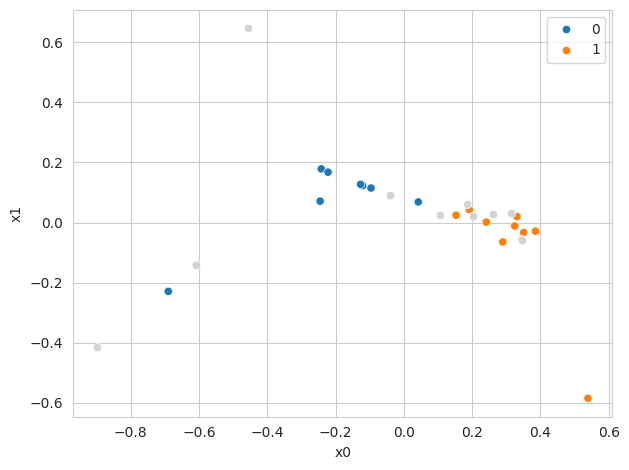

In [9]:
sns.scatterplot(x='x0', y='x1', data=train, hue='group')
sns.scatterplot(x='x0', y='x1', data=test, color='lightgrey')
plt.tight_layout()

We can now use the data in the training set to infer the parameters of a logistic regression model:

In [10]:
logreg = LogisticRegression()
logreg = logreg.fit(train[['x0', 'x1']], train['group'])
print(logreg.coef_)

[[ 2.05862995 -0.47649972]]


We can now use the model to predict the classes using the node features in the test set:

In [11]:
test['predicted'] = logreg.predict(test[['x0', 'x1']])

Let us plot the predictions for the test set along with the fitted decision boundary of the logistic regression classifier.

/home/jovyan/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


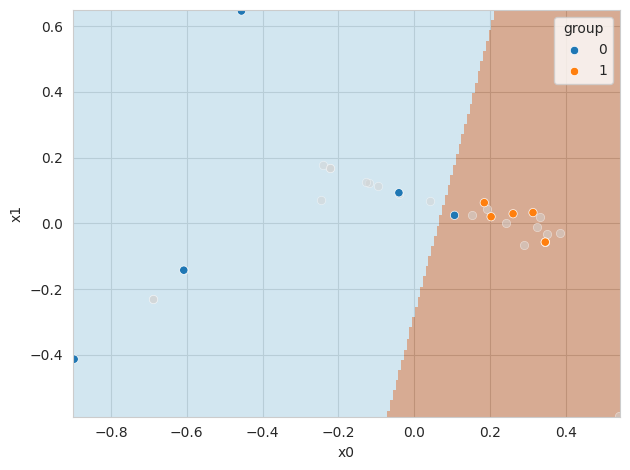

In [12]:
min_x = min(train['x0'].min(), test['x0'].min())
min_y = min(train['x1'].min(), test['x1'].min())

max_x = max(train['x0'].max(), test['x0'].max())
max_y = max(train['x1'].max(), test['x1'].max())

x_mesh, y_mesh = np.meshgrid(np.linspace(min_x, max_x, 200), np.linspace(min_y, max_y, 200))
class_probs = logreg.decision_function(np.c_[x_mesh.ravel(), y_mesh.ravel()])
#print(logits)

#class_probs = torch.softmax(logits, dim=0)
z = np.array(class_probs).reshape(x_mesh.shape)

test['predicted'] = logreg.predict(test[['x0', 'x1']])

fig, ax = plt.subplots()
plt.pcolormesh(x_mesh, y_mesh, z > 0, cmap=plt.cm.Paired, alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=train, color='lightgray', alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=test, hue='group')
plt.tight_layout()

For this (admittedly simple) example, we obtain a relatively high accuracy. We could probably further improve this if we were to use a higher-dimensional embedding (which we did not do here for illustrative purposes).

In [13]:
metrics.balanced_accuracy_score(logreg.predict(test[['x0', 'x1']]), test[['group']])

np.float64(0.9285714285714286)

## Supervised Link Prediction

So far, we have studied link prediction as an unsupervised problem. Let us recapitulate this: We split the network in a training and a test network along the edges, so both networks contained the same set of nodes. We then considered the number of edges in the test network and generated the same number of negative samples (i.e. node pairs that are not connected by a link). This yields a balanced binary classification problem, i.e. we obtain a test set with a set of node pairs where half are connected by a link and half are not.

We then calculated node similarities based on the edges in the training network and used them to rank node pairs. We finally used this ranking to evaluate a binary classifier in a test set that contained true positives (i.e. node pairs connected by links) and true negatives (i.e. node pairs not connected by a link). Even though we split the network into a training and a test set for the purpose of evaluation, we adopted an **unsupervised approach** that did not require training data to learn any model parameters. We just used the training network to calculate node similarities and evaluated the ranking of node pairs based on the AUC of a simple classifier that uses a variable discrimination threshold. This approach of ranking node pairs by similarity helps us, e.g. when we want to predict a small number of connections (say: 10) in a recommender system. But since we did not learn a discrimination threshold for node similarities, we cannot use it to assign class labels with high confidence.

In the following, we address this issue by taking a supervised approach to link prediction. We first reuse code from week 08 to generate a random geometric graph based on randomly assigned node positions in a $d$-dimensional latent space.

In [14]:
def random_geometric_net(n, dim, dist, rule, pos, **kwargs):

    # generate empty graph and assign random node positions
    net = pp.Network(directed=False)

    positions = {}
    if pos is not None:
        positions = pos.copy()
    for i in range(n):
        v = pp.Node(str(i))
        if pos is None:
            positions[v.uid] = np.array([np.random.random() for x in range(dim)])
        net.add_node(v)
    # compute node similarity and add edges
    for v in net.nodes:
        for w in net.nodes:
            if rule(dist(positions[v.uid], positions[w.uid]), **kwargs) and v.uid != w.uid:
                net.add_edge(v,w)
    return net, positions

We use Euclidean distance to generate links using a soft connection rule.

In [15]:
def euclidean_dist(x, y):
    return np.linalg.norm(x-y)

def hard_rule(dist, **kwargs):
    if dist < kwargs['threshold']:
        return True
    else:
        return False

def soft_rule(dist, **kwargs):
    p = kwargs['beta'] * np.exp(-dist/kwargs['alpha'])
    if np.random.random() <= p:
        return True
    else:
        return False

def to2d(pos):
    return { k: v[:2] for k,v in pos.items() }

In [16]:
n_rgr, pos = random_geometric_net(n=100, dim=2, dist=euclidean_dist, rule=soft_rule, pos=None, alpha=0.03, beta=70)
n_rgr = n_rgr.largest_connected_component()
n_rgr.plot(layout=to2d(pos), edge_color='gray')

We can now split the network in a training and test network (again splitting along the edges).

In [17]:
train, test = pp.algorithms.evaluation.train_test_split(n_rgr, test_size = 0.5, split='edge')

train = train.largest_connected_component()
test = train.largest_connected_component()

train_df = pd.DataFrame([ (e.v.uid, e.w.uid, 1) for e in train.edges ], columns=['v', 'w', 'link'])
test_df = pd.DataFrame([ (e.v.uid, e.w.uid, 1) for e in test.edges ], columns=['v', 'w', 'link'])
print(test_df)

      v   w  link
0     0  43     1
1     0  60     1
2     0  62     1
3     0  66     1
4     0  82     1
..   ..  ..   ...
201  93  95     1
202  97   2     1
203  97  87     1
204  98  30     1
205  99  17     1

[206 rows x 3 columns]


Different from before, we need to train a model with instances of the positive and negative class. We must thus generate negative pairs both in the training and test set. For unsupervised link prediction, we only needed negative pairs to evaluate our similarity ranking in terms of the ROC, so it was sufficient to generate negative pairs for the test set.

In [18]:
def create_negative_pairs_test(train, test):
    nodes = [v.uid for v in test.nodes]
    num = 0
    negative = []
    while num<test.number_of_edges():
        v, w = np.random.choice(nodes, 2, replace=False)
        if (v, w) not in test.edges and (v, w) not in train.edges:
            negative.append((v, w, 0))
            num += 1

    negative = pd.DataFrame(negative, columns=['v', 'w', 'link'])
    return negative

In [19]:
def create_negative_pairs_train(train, test):
    nodes = [v.uid for v in train.nodes]
    num = 0
    negative = []
    while num<train.number_of_edges():
        v, w = np.random.choice(nodes, 2, replace=False)
        if (v, w) not in test.edges and (v, w) not in train.edges:
            negative.append((v, w, 0))
            num += 1

    negative = pd.DataFrame(negative, columns=['v', 'w', 'link'])
    return negative

In [20]:
negative_test = create_negative_pairs_test(train, test)
negative_train = create_negative_pairs_train(train, test)
test_df = pd.concat([test_df, negative_test], ignore_index=True)
test_df = test_df.reset_index()
train_df = pd.concat([train_df, negative_train], ignore_index=True)
train_df = train_df.reset_index()

Let's verify that we have instances with `link=0` and `link=1` in both data frames:

In [21]:
print(train)
print(train_df)

Uid:			0x7fee2f90b550_train
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	94
Number of edges:	206
     index   v   w  link
0        0   0  43     1
1        1   0  60     1
2        2   0  62     1
3        3   0  66     1
4        4   0  82     1
..     ...  ..  ..   ...
407    407  67  88     0
408    408  51  71     0
409    409  15  49     0
410    410  64  79     0
411    411  96   4     0

[412 rows x 4 columns]


In [22]:
print(test)
print(test_df)

Uid:			0x7fee2f90b550_train
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	94
Number of edges:	206
     index   v   w  link
0        0   0  43     1
1        1   0  60     1
2        2   0  62     1
3        3   0  66     1
4        4   0  82     1
..     ...  ..  ..   ...
407    407  70  14     0
408    408  75  73     0
409    409  39   6     0
410    410  35  92     0
411    411  48  94     0

[412 rows x 4 columns]


We can now compute our embedding. We reuse the Laplacian embedding that worked well in our previous experiments.

In [23]:
vecs = laplacian_embedding(train, laplacian(train), d=2)

Different from our experiments before, we now want to use those data to train a classifier that can use features with multiple dimensions. We thus do not need to feel restricted to predict links based on a scalar similarity threshold. We can rather use methods that assign a single vectorial feature to a node pair, based on the embeddings of the two adjacent nodes. A popular approach is to use the so-called Hadamard operator, which is simply the element-wise product of the two vectors. The [Hadamard operator](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) has a number of interesting properties, which makes it a reasonable choice for this task.

In [24]:
def hadamard(x, y):
    # element-wise multiplication of vectors
    return np.multiply(x, y)

We define a function that calculates the Hadamard operator based on the embeddings of the nodes, and assigns it to additional columns of our data frame:

In [25]:
def assign_features(pos, df):
    features = []
    for index, row in df.iterrows():
        f = hadamard(pos[row['v']], pos[row['w']])
        for i in range(len(f)):
            df.loc[index, 'x{0}'.format(i)] = f[i]

In [26]:
assign_features(vecs, train_df)

In [27]:
train_df

,index,v,w,link,x0,x1
0,0,0,43,1,0.655849,0.000155
1,1,0,60,1,0.590070,0.000316
2,2,0,62,1,0.643372,-0.000358
3,3,0,66,1,0.647167,-0.000015
4,4,0,82,1,0.642110,-0.000469
...,...,...,...,...,...,...
407,407,67,88,0,-0.789334,0.150114
408,408,51,71,0,-0.599962,-0.058539
409,409,15,49,0,1.180605,-1.395908
410,410,64,79,0,-0.582474,-0.159673


We have assigned each component to a separate column so that we can easily get the features of all nodes as multi-dimensional numpy array, that can be passed to classifier models in sklearn:

In [28]:
train_df.iloc[:,4:].to_numpy()

array([[ 6.55849404e-01,  1.54815524e-04],
       [ 5.90070436e-01,  3.16210214e-04],
       [ 6.43371833e-01, -3.58447307e-04],
       [ 6.47167341e-01, -1.46749106e-05],
       [ 6.42110346e-01, -4.68533696e-04],
       [ 4.76951732e-01,  4.85211014e-04],
       [ 3.34182852e+00,  6.46973213e-02],
       [ 2.31067777e+00,  5.01954216e-02],
       [ 1.29854099e+00,  2.30584118e-02],
       [ 1.52390608e+00,  2.80405303e-02],
       [ 8.86878500e-01,  2.87325044e+00],
       [ 8.68641862e-01,  2.69709154e+00],
       [ 8.00929399e-01,  2.37781268e+00],
       [ 9.12508859e-01,  2.95814004e+00],
       [ 8.63517489e-01,  2.92433227e+00],
       [ 6.71096847e-01,  1.90208531e-02],
       [ 5.93968937e-01,  2.60793708e-02],
       [ 6.91233853e-01,  6.70553943e-04],
       [ 7.58119621e-01, -3.11195488e-05],
       [ 7.02308315e-01,  7.29443040e-04],
       [ 8.11290965e-01,  3.44599084e-04],
       [ 1.20260016e+00, -1.28623523e-03],
       [ 1.69536987e+00,  7.56978951e-01],
       [ 1.

We can actually make a scatter plot of the node pair features (i.e. the Hadamard product of node feature vectors), where we color connected node pairs in orange and not connected node pairs in blue. This highlights the patterns that can be used by the machine learning classifier.

<Axes: xlabel='x0', ylabel='x1'>

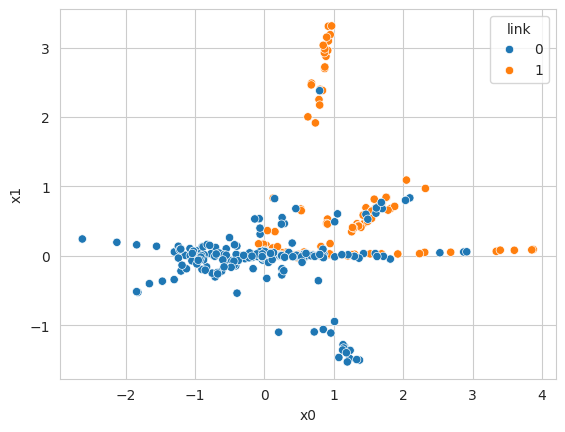

In [29]:
sns.scatterplot(x='x0', y='x1', data=train_df, hue='link')

Let us now use the data to train a multi-dimensional binary logistic regression model. We pass the features and the ground truth for node pairs in our training set:

In [30]:
logreg = LogisticRegression()
logreg = logreg.fit(train_df.iloc[:,4:].to_numpy(), train_df['link'].to_numpy())
print(logreg.coef_)

[[1.01545606 1.38172561]]


Let us now evaluate the precision of the trained classifier in the test network. For this, we first need to compute the embedding based on the test network and then assign the features to the test data frame (which already contains negative samples):

In [31]:
vecs = laplacian_embedding(test, normalized_laplacian(test), d=2)
assign_features(vecs, test_df)
test_df

,index,v,w,link,x0,x1
0,0,0,43,1,14.517997,0.038745
1,1,0,60,1,23.068664,-0.011061
2,2,0,62,1,21.826327,0.237809
3,3,0,66,1,20.414268,0.105797
4,4,0,82,1,24.544483,0.311702
...,...,...,...,...,...,...
407,407,70,14,0,2.134755,-0.033385
408,408,75,73,0,-26.659005,2.771197
409,409,39,6,0,-18.334543,0.685563
410,410,35,92,0,-3.029716,-2.258141


We finally predict links and evaluate the f1-score of our prediction:

In [32]:
print(metrics.f1_score(logreg.predict(test_df.iloc[:,4:].to_numpy()), test_df['link'].to_numpy()))

0.8


To simplify the application of this approach, we write a function that performs all the necessary steps for training and evaluation of the classifier. We also include a parameter that controls the number of dimensions of the embedding used for link prediction:

In [33]:
def evaluate_link_prediction(network, dimensions=5, test_size=0.25):
    # Split network into training and test set 
    train, test = pp.algorithms.evaluation.train_test_split(n, test_size = test_size, split='edge')

    train = train.largest_connected_component()
    test = test.largest_connected_component()

    # Generate pandas dataframe
    train_df = pd.DataFrame([ (e.v.uid, e.w.uid, 1) for e in train.edges ], columns=['v', 'w', 'link'])
    test_df = pd.DataFrame([ (e.v.uid, e.w.uid, 1) for e in test.edges ], columns=['v', 'w', 'link'])

    # add negative samples
    negative_test = create_negative_pairs_test(train, test)
    negative_train = create_negative_pairs_train(train, test)
    test_df = pd.concat([test_df, negative_test], ignore_index=True)
    test_df = test_df.reset_index()
    train_df = pd.concat([train_df, negative_train], ignore_index=True)
    train_df = train_df.reset_index()

    # representation learning on training network / assign features to training set
    vecs = laplacian_embedding(train, laplacian(train), d=dimensions)
    assign_features(vecs, train_df)

    # fit model parameters
    logreg = LogisticRegression()
    logreg = logreg.fit(train_df.iloc[:,4:].to_numpy(), train_df['link'].to_numpy())

    # representation learning on test network / assign features to test set
    vecs = laplacian_embedding(test, normalized_laplacian(test), d=dimensions)
    assign_features(vecs, test_df)

    # compute f1 score of prediction
    return metrics.f1_score(logreg.predict(test_df.iloc[:,4:].to_numpy()), test_df['link'].to_numpy())

In [34]:
evaluate_link_prediction(n_rgr, dimensions=5)

np.float64(0.9411764705882353)

Mimicking our analysis of the influence of the embedding dimension on unsupervised link prediction, we can study how the number of embedding dimensions affects the performance of supervised link prediction:

Running prediction for d=1 dimensions
Running prediction for d=2 dimensions
Running prediction for d=3 dimensions
Running prediction for d=4 dimensions
Running prediction for d=5 dimensions


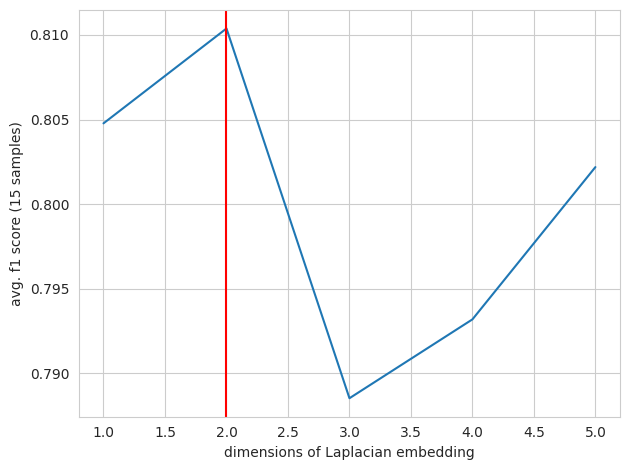

In [35]:
f1 = []
for d in range(1, 6):
    print('Running prediction for d={0} dimensions'.format(d))
    x = 0
    for i in range(15):
        x += evaluate_link_prediction(n_rgr, dimensions=d)
    f1.append(x/15)
plt.plot(range(1,6), f1)
plt.axvline(x=2, color='red')
plt.xlabel('dimensions of Laplacian embedding')
plt.ylabel('avg. f1 score (15 samples)')
plt.tight_layout()

We can repeat the same analysis for an empirical network:

In [36]:
n = pp.io.graphtool.read_netzschleuder_network('karate', 77)

Running prediction for d=1 dimensions
Running prediction for d=2 dimensions
Running prediction for d=3 dimensions
Running prediction for d=4 dimensions
Running prediction for d=5 dimensions
Running prediction for d=6 dimensions
Running prediction for d=7 dimensions
Running prediction for d=8 dimensions
Running prediction for d=9 dimensions


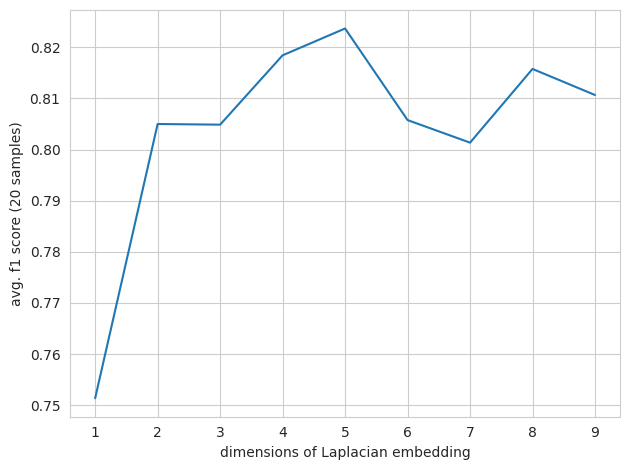

In [37]:
f1 = []
for d in range(1, 10):
    print('Running prediction for d={0} dimensions'.format(d))
    x = 0
    for i in range(20):
        x += evaluate_link_prediction(n, dimensions=d, test_size=0.5)
    f1.append(x/20)
plt.plot(range(1,10), f1)
plt.xlabel('dimensions of Laplacian embedding')
plt.ylabel('avg. f1 score (20 samples)')
plt.tight_layout()

## Supervised learning  in networks with non-linear patterns

Above, we have used logistic regression to address supervised node classification and link prediction. Like other linear classification techniques (e.g. support vector machines without non-linear kernels), logistic regression gives rise to a linear decision boundary, i.e. it is not expressive enough to address machine learning in many real data sets. Let us motivate this in a synthetic example for a network, where node classification requires non-linear classification techniques. 

We will generate a network based on the circles data set in sklearn:

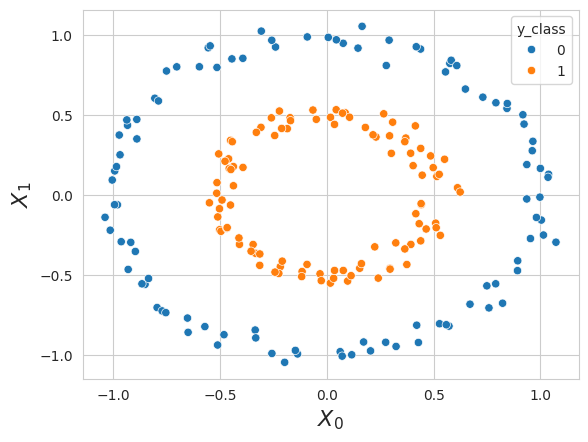

In [38]:
x, c = make_circles(n_samples=200, noise = 0.05, factor = 0.5)
data = pd.DataFrame( {'x0': x[:,0], 'x1': x[:,1], 'y_class': c })

sns.scatterplot(x='x0', y='x1', data=data, hue='y_class')
plt.xlabel(r'$X_0$', fontsize=16)
plt.ylabel(r'$X_1$', fontsize=16);

In [39]:
net = pp.Network(directed=False)
for i, row in data.iterrows():
    net.add_node(str(i), pos=np.array([row['x0'], row['x1']]), g=c[i])
for v in net.nodes:
    for w in net.nodes:
        if soft_rule(euclidean_dist(v['pos'], w['pos']), alpha=0.05, beta=70) and v.uid != w.uid:
            net.add_edge(v, w)
print(net)

Uid:			0x7fee2d37b4f0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	200
Number of edges:	1269


In [40]:
colors = {}
colors[0] = 'orange'
colors[1] = 'CornflowerBlue'
for v in net.nodes:
    v['color'] = colors[v['g']]
net.plot(edge_color='grey')

In [41]:
nodes = [(v.uid, v['g']) for v in net.nodes]
data = pd.DataFrame(nodes, columns=['v', 'group'])

train, test = train_test_split(data, test_size=0.3)
print(train)

       v  group
111  111      1
31    31      1
78    78      1
162  162      0
49    49      1
..   ...    ...
30    30      1
92    92      0
171  171      1
66    66      0
104  104      0

[140 rows x 2 columns]


In [42]:
def assign_features(embedding, df):
    features = []
    for index, row in df.iterrows():
        f = embedding[row['v']]
        for i in range(len(f)):
            df.loc[index, 'x{0}'.format(i)] = f[i]        

In [43]:
embedding = laplacian_embedding(net, laplacian(net), d=2)

assign_features(embedding, train)
assign_features(embedding, test)
assign_features(embedding, data)

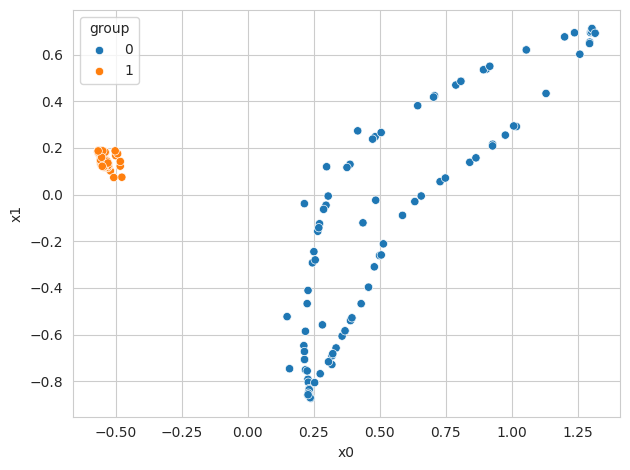

In [44]:
sns.scatterplot(x='x0', y='x1', data=data, hue='group')
plt.tight_layout()

In [45]:
logreg = LogisticRegression()
logreg = logreg.fit(train[['x0', 'x1']], train['group'].to_numpy())
print(logreg.coef_)

[[-4.57460132  1.77713453]]


/home/jovyan/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


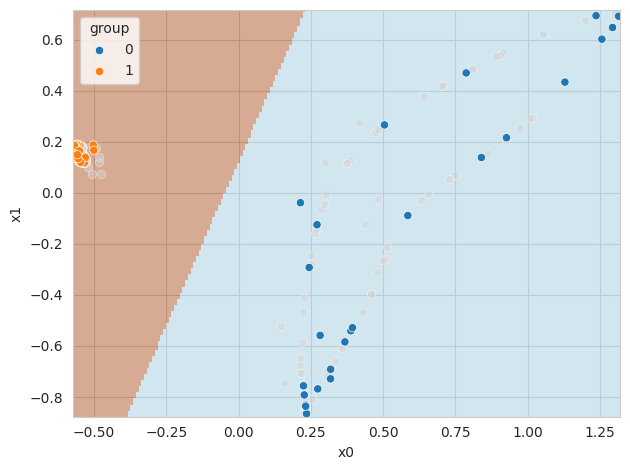

In [46]:
min_x = data['x0'].min()
min_y = data['x1'].min()

max_x = data['x0'].max()
max_y = data['x1'].max()

x_mesh, y_mesh = np.meshgrid(np.linspace(min_x, max_x, 200), np.linspace(min_y, max_y, 200))
class_probs = logreg.decision_function(np.c_[x_mesh.ravel(), y_mesh.ravel()])

z = np.array(class_probs).reshape(x_mesh.shape)

test['predicted'] = logreg.predict(test[['x0', 'x1']])

fig, ax = plt.subplots()
plt.pcolormesh(x_mesh, y_mesh, z > 0, cmap=plt.cm.Paired, alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=train, color='lightgray', alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=test, hue='group')
plt.tight_layout()